In [2]:
import numpy as np
import tensorflow as tf

### 提要
1. 三个概念：
    - 计算图：tf.Graph
    - 张量： tf.Tensor
    - 会话： tf.Session
2. 实现神经网络的训练过程

### 计算模型--计算图 
tensor:张量，flow:计算模型,graph:计算图

#### 计算图的使用

In [2]:
a = tf.constant([1.0, 2.0], name='a')
b = tf.constant([2.0, 3.0], name='b')
result = a + b

# 查看张量所属计算图
print(a.graph)

In [6]:
# 在计算图上定义和使用变量
g1 = tf.Graph()    # 实例化计算图
with g1.as_default():
    # 在计算图中定义变量，并设置初始值为 0 
    v = tf.get_variable(
    'v', shape=[1], initializer=tf.zeros_initializer)
    
# 创建g2 计算图
g2 = tf.Graph()
with g2.as_default():
    # 在计算图g2中定义变量 v, 并设置为初始值为 1
    v = tf.get_variable(
    'v', shape=[1], initializer=tf.ones_initializer)
    
# 在计算图读取变量的取值
with tf.Session(graph=g1) as sess:
    tf.global_variables_initializer().run()
    with tf.variable_scope('', reuse=True):
        print(sess.run(tf.get_variable('v')))
    
# 读取g2计算图中的变量v
with tf.Session(graph=g2) as sess:
    tf.global_variables_initializer().run()
    with tf.variable_scope('', reuse=True):
        print(sess.run(tf.get_variable('v')))

[0.]
[1.]


以上定义的两个计算图，每个计算图都定义了一个变量‘v’，在不同的计算图中相同变量名的变量的值不同。计算图不仅仅能隔离张量和计算，还提供了管理计算图和计算的机制，通过tf.Graph.device函数来指定计算机的运行设备。将加法计算运行在GPU上：

In [3]:
g = tf.Graph()
#  指定预算设备
with g.device('/gpu:0'):
    result = a + b

### 数据模型--张量
#### 张量的概念

- 从功能上可以简单的理解为多维数组
- 从代码上看 tensorflow 中不直接采用数组的形式，张量中并没有真正保存这些数字，它保存的是如何得到这些数字的计算过程。
- 张量的三个属性：name, shape, type

In [4]:
# tf.constant 是一个计算，计算的结果是一个张量，保存在变量中
# 其计算结果也是一个张量
a = tf.constant([1.0, 2.9], name='a')
b = tf.constant([2.0, 2.1], name='b')
print(type(a))
print(a)

result = tf.add(a, b, name='add')
print(type(result))
print(result)

# 指定张量的数据类型和维度
l1 = [1, 2, 3, 4]
c = tf.constant(l1, name='c', dtype=tf.float32, shape=(2, 2))
print(c)

<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("a_1:0", shape=(2,), dtype=float32)
<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("add_2:0", shape=(2,), dtype=float32)
Tensor("c:0", shape=(2, 2), dtype=float32)


#### 张量的使用
- 对中间计算结果的引用，如获取中间变量的某些维度
- 计算图构建完成后，获得计算结果，得到真实数字

### 运行模型--会话
使用会话执行定义好的运算，会话拥有程序运行时的所有资源，计算完成后需要关闭会话帮助系统回收资源。两种模式：
- 明确调用会话生成函数和关闭函数
- 通过上下文管理器管理会话

In [5]:
# 1.第一种会话管理方式,程序异常时就不会执行关闭函数
sess = tf.Session()
# 使用会话得到运算结果
print('张量 c 的数值\n', sess.run(c))
sess.close()

# 2.第二种会话管理方式，上下文退出时会话关闭释放资源
with tf.Session() as sess:
    print('张量 a 的数值', sess.run(a))
    
# 3.通过默认会话获得张量的取值
sess = tf.Session()
with sess.as_default():
    print('张量 b 的数值', b.eval())

张量 c 的数值
 [[1. 2.]
 [3. 4.]]
张量 a 的数值 [1.  2.9]
张量 b 的数值 [2.  2.1]


### 实现神经网络
#### tensorflow 游乐场及神经网络
神经网络解决分类问题主要分为以下4个步骤：
1. 提取特征向量作为神经网络的输入
2. 定义神经网络的结构，并定义如何从神经网络的输入得到输出（向前传播）
3. 通过训练数据来调整神经网络中的参数取值
4. 使用训练好的模型来预测数据

#### 向前传播算法简介
全连接网络结构的向前出传播算法：

神经元是构成神经网络的最小单元，一个神经元由多个输入和一个输出，最简单神经元的输出就是所有输入的加权和。
不同输入的权重就是神经元的参数，神将网络的优化过程就是参数的取值过程。

全连接神经网络指相邻层之间额任意两个节点元都有连接。

**神经网络向前传播结果的三要素**
1. 神经网络的输入：实体中提取的特征向量
2. 神将网络的连接结构：全连接
3. 神经网络边上的取值：权重

In [6]:
# tensorflow实现矩阵向前传播过程，模拟一个隐藏层包含3个神经元的数据结构
# 生成模拟数据
np.random.seed = 9
x = tf.constant([0.7, 0.9], name='x', dtype=tf.float64, shape=(1, 2))   # 样本的两个特征
w1 = tf.constant(np.random.randn(6), name='w1', shape=(2, 3))
w2 = tf.constant(np.random.randn(3), name='w1', shape=(3, 1))

# 计算
# 1.计算每个隐藏测结果
a = tf.matmul(x, w1)    # 矩阵的乘法:对应行乘对应列的和
y = tf.matmul(a, w2)

# 查看计算结果
with tf.Session() as sess:
    print('神经元的值：',sess.run(a))
    print('输出结果：',sess.run(y))
    print('样本值：',sess.run(x))    
    print('权重：',sess.run(w2))

神经元的值： [[ 2.51649837 -0.06192953  0.98737276]]
输出结果： [[2.19007899]]
样本值： [[0.7 0.9]]
权重： [[0.82353361]
 [1.11502315]
 [0.18909867]]


#### 神经网络参数和tensorflow变量
- 神经网络参数的组织、保存、使用
- 变量 tf.Variable:保存和更新神经网络中的参数
- 类型是变量的一个重要概念，默认类型为tf.float32,操作不同类型的变量时会报错
- 维度也是变量的一个重要概念，但是维度可以通过validaate_shape=False改变，一般用的较少

In [14]:
# 声明矩阵变量的方法
# 生成服从正态分布标准差位2，平均值为0，取值类型为tf.float32的 2×3的矩阵
weights = tf.Variable(tf.random_normal([2, 3], stddev=2.0))
# 随机数生成函数
# 函数名称              | 分布方式  | 参数
# tf.random_normal()   | 正态分布  | 标准差，均值，类型
# tf.random_uniform()  | 均匀分布  | 最小、最大值，类型
# tf.random_gamma()    | Gamma分布| 形状参数、尺度参数、类型
# tf.truncated_notmal()| 正态分布  | 标准差，均值，类型

# 生成常数
# tf.zeros([2, 3], int32)   # 生成2×3的全0矩阵
# tf.ones()       # 全 1 矩阵
# tf.fill([2, 3], 8)     # 以某个数填充的矩阵
# tf.constant()     # 指定值的矩阵

# 使用变量实现4.2中的神经网络
x = tf.constant([0.7, 0.9], shape=(1, 2))
w1 = tf.Variable(tf.random_normal((2, 3), stddev=1, seed=1)) # 设置随机数种子
w2 = tf.Variable(tf.random_normal((3, 1), stddev=1, seed=1))

# 向前传播算法神经网络的实现
a = tf.matmul(x, w1)
y = tf.matmul(a, w2)

sess = tf.Session()
# 计算y之前，需要将所有用到的变量初始化，否则不能得到计算结果
# 1.单个变量的初始化
# sess.run(w1.initializer)    # 初始化
# sess.run(w2.initializer)

# 2.将所有变量初始化，
init_op = tf.global_variables_initializer()
sess.run(init_op)

print('神经元输出结果：', sess.run(y))
sess.close()

神经元输出结果： [[3.957578]]


#### 训练神将网络模型
监督学习的重要思想：在已知答案的标注数据集上，模型给出的预测结果要尽量接近真实答案。神经网络中最常用的方法是反向传播算法。
1. 反向传播算法流程图
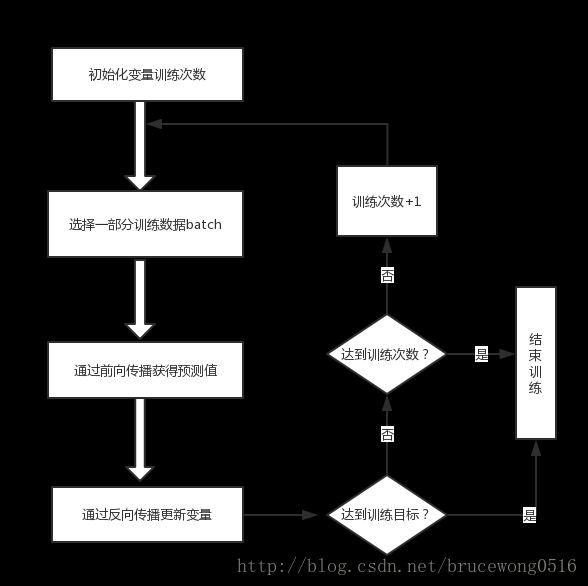

选取小部分数据（batch）--> 通过向前传播算法得到预测结果 --> 计算预测值和真实值间的差距 --> 基于此差距反向传播算法更新神经网络中相关的参数取值

In [16]:
# 通过palceholder 实现向前传播算法的
# 作用：避免神经网络中产生大量的常量，相当于定义了一个位置，这个位置的数据在程序运行时再指定
w1 = tf.Variable(tf.random_normal([2, 3], stddev=1, seed=9))
w2 = tf.Variable(tf.random_normal([3, 1], stddev=1, seed=9))

# 定义定义placeholder 作为存放输入数据的地方，
x = tf.placeholder(tf.float32, shape=[1, 2], name='input')    # x未指定值
a = tf.matmul(x, w1)
y = tf.matmul(a, w2)

sess = tf.Session()
# 初始化所有变量
init_op = tf.global_variables_initializer()
sess.run(init_op)

# 直接运行，将报错  InvalidArgumentError
# print(sess.run(y))

# 需要指定输入的变量，即
print(sess.run(y, feed_dict={x: [[0.7, 0.9]]}))
sess.close()

[[-0.6053763]]


In [2]:
# 以上为单个样本的训练结果，当每次传入多个样本时
w1 = tf.Variable(tf.random_normal([2, 3], stddev=1, seed=9))
w2 = tf.Variable(tf.random_normal([3, 1], stddev=1, seed=9))

# 定义定义placeholder 作为存放输入数据的地方，
x = tf.placeholder(tf.float32, shape=[3, 2], name='input')    # x未指定值
a = tf.matmul(x, w1)
y = tf.matmul(a, w2)

sess = tf.Session()
# 初始化所有变量
init_op = tf.global_variables_initializer()
sess.run(init_op)

print(sess.run(y, feed_dict={x: [[0.7, 0.9], [0.1, 0.4], [0.5, 0.8]]}))

[[-0.6053763]
 [-0.6433336]
 [-0.7547992]]


In [ ]:
# 通过反向传播算法，调整神将网路的参数取值
y = tf.sigmoid(y)    # 将y转化为0-1间的数值
# 定义损失函数来刻画预测值与真实值间的差距
# 真实值与预测值之间的交叉熵
cross_entropy = -tf.reduce_mean(
    y_ * tf.log(tf.clip_by_value(y, 1e-10, 1.0))
    + (1-y) * tf.log(clip_by_value(1-y, 1e-10, 1.0))
)

# 定义学习率
learning_rate = 0.001

# 定义反向传播算法优化神经网络中的参数
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
# tensorflow 支持10种不同的优化器，常用的三种
# 1. tf.train.AdamOptimizer()
# 2. tf.train.GradientDescentOptimizer()
# 3. tf.train.MomentumOptimizer()

#### 完整神经网络样例

In [13]:
# 定义训练数据的大小
batch_size = 8

# 定义神经网络参数
w1 = tf.Variable(tf.random_normal([2, 3], stddev=1, seed=9))
w2 = tf.Variable(tf.random_normal([3, 1], stddev=1, seed=9))

# 生成模拟数据
# 在一个维度上使用None可以方便使用不同batch 大小
x = tf.placeholder(tf.float32, shape=(None, 2), name='x-input')
y_ = tf.placeholder(tf.float32, shape=(None, 1), name='y-input')

# 定义神经网络向前传播过程
a = tf.matmul(x, w1)
y = tf.matmul(a, w2)

# 损失函数和反向传播算法
y = tf.sigmoid(y)
cross_entropy = -tf.reduce_mean(
    y_ * tf.log(tf.clip_by_value(y, 1e-10, 1.0))
    + (1 - y)*tf.log(tf.clip_by_value(1-y, 1e-10, 1.0))
)
train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)

# 生成模拟数据
rdm = np.random.RandomState(1)
dataset_size = 128

X = rdm.rand(dataset_size, 2)    # 128×2维

# 定义规则生成样本标签, x1+x2 大于 1-->0; 小于 1-->1
Y = [[int(x1 + x2 < 1)] for x1, x2 in X]

# 创建会话来运行程序
with tf.Session() as sess:
    # 初始化变量
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    print('训练神经网络前参数w1:\n', sess.run(w1))
    print('训练神经网络前参数w2:\n', sess.run(w2))
    
    # 设定训练轮数
    STEPS = 20000
    for i in range(STEPS):
        # 每轮选取batch 个样本进行训练
        start = (i * batch_size) % dataset_size
        end = min(start + batch_size, dataset_size)
        
        # 选取样本训练神经网络更新参数
        sess.run(train_step,
                 feed_dict={x: X[start:end], y_: Y[start:end]})
        if i%1000 == 0:
            total_cross_entropy = sess.run(cross_entropy,
                                          feed_dict={x: X, y_:Y})
            print('交叉熵', total_cross_entropy)
    
    print('训练神经网络后参数w1:\n', sess.run(w1))
    print('训练神经网络后参数w2:\n', sess.run(w2))

训练神经网络前参数w1:
 [[ 1.1550728 -0.4910573  0.4444805]
 [-2.4383585 -1.9960194 -0.4842411]]
训练神经网络前参数w2:
 [[ 1.1550728]
 [-0.4910573]
 [ 0.4444805]]
交叉熵 0.7433128
交叉熵 0.15372932
交叉熵 0.062069092
交叉熵 0.036643602
交叉熵 0.024149176
交叉熵 0.016729249
交叉熵 0.0119739715
交叉熵 0.00883453
交叉熵 0.006709559
交叉熵 0.005232793
交叉熵 0.0041648312
交叉熵 0.0033615697
交叉熵 0.0027321307
交叉熵 0.0022256207
交叉熵 0.0018097104
交叉熵 0.00146653
交叉熵 0.0011813594
交叉熵 0.00094564905
交叉熵 0.00075105013
交叉熵 0.0005922084
训练神经网络后参数w1:
 [[ 5.253691  -6.420101   7.150643 ]
 [ 1.333112  -7.604872   5.9233236]]
训练神经网络后参数w2:
 [[ 3.2840712]
 [-5.731046 ]
 [ 7.3852067]]


In [14]:
# 使用上面训练出来的参数，再进行模型预测
x = tf.placeholder(tf.float32, shape=(None, 2), name='x-input')
a = tf.matmul(x, w1)
y = tf.matmul(a, w2)

rdm = np.random.RandomState(1)
dataset_size = 128

X = rdm.rand(dataset_size, 2)    # 128×2维

# 定义规则生成样本标签, x1+x2 大于 1-->0; 小于 1-->1
Y = [[int(x1 + x2 < 1)] for x1, x2 in X]

with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    y_predict = sess.run(y, feed_dict={x: X[:5]})
    print(y_predict)
    print(sess.run(tf.sigmoid(y_predict)))

[[-0.7384516 ]
 [-0.62005   ]
 [ 0.07074462]
 [-0.37871817]
 [-0.40198714]]
[[0.32334283]
 [0.34977007]
 [0.5176788 ]
 [0.40643606]
 [0.400835  ]]


#### 总结
训练神经网络的过程可以分为以下三个步骤：
1. 定义神经网络的结果和向前传播的输出结果；
2. 定义损失函数及选择反向传播优化算法。
3. 生成会话，并且在训练数据上反复运行反向传播优化算法。

[[0], [1], [1], [1], [1]]